# Training an Attention Model on Tensorflow Datasets
## Prerequisites

In [1]:
import json
import os
from typing import Any, Callable, List, Optional, Tuple

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from IPython.core.display import display
from mmproteo.utils import log, paths, utils, visualization
from mmproteo.utils.formats.tf_dataset import DatasetLoader
from mmproteo.utils.ml import callbacks, evaluation
from official.modeling import tf_utils
from official.nlp.modeling.models.seq2seq_transformer import Seq2SeqTransformer, TransformerDecoder, TransformerEncoder
from official.nlp.modeling.ops import beam_search

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1,3,4,7"

In [4]:
#tf.debugging.set_log_device_placement(True)
GPUs = tf.config.list_physical_devices('GPU')
GPUs

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

## Configuration

In [5]:
!pwd

/hpi/fs00/home/mirko.krause/masterthesis/pride-downloader/notebooks


In [6]:
if os.getcwd() == "/tf":
    os.chdir(os.path.join('workspace', 'notebooks'))

In [7]:
!pwd

/hpi/fs00/home/mirko.krause/masterthesis/pride-downloader/notebooks


In [8]:
DUMP_PATH = "/scratch/mirko.krause/pdeep"
TRAINING_COLUMNS_DUMP_PATH = os.path.join(DUMP_PATH, "training_columns")
FILES_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "file_*.parquet")

In [9]:
print(f"dump path = {DUMP_PATH}")
THREAD_COUNT = min(int(os.cpu_count()/2), 16)
STATISTICS_FILE_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "statistics.parquet")
DATASET_DUMP_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "tf_datasets")
PROCESSING_FILE_PATH = os.path.join(DATASET_DUMP_PATH, "processing_info.json")

dump path = /scratch/mirko.krause/pdeep


In [10]:
SEQ = 'peptide_sequence'

In [11]:
logger = log.create_logger(
    name='mmproteo_attention_model',
    verbose=True,
    log_dir=DUMP_PATH,
)

2021-08-08 14:47:06,697 - mmproteo_attention_model: Logging to file '/scratch/mirko.krause/pdeep/mmproteo_attention_model.log' and to stderr


In [12]:
with open(PROCESSING_FILE_PATH, 'r') as file:
    PROCESSING_INFO = json.loads(file.read())
PROCESSING_INFO

{'padding_characters': {'peptide_sequence': '_',
  'mz_array': 0.0,
  'intensity_array': 0.0},
 'padding_lengths': {'mz_array': 89,
  'intensity_array': 89,
  'peptide_sequence': 30},
 'idx_to_char': {'0': 'A',
  '1': 'C',
  '2': 'D',
  '3': 'E',
  '4': 'F',
  '5': 'G',
  '6': 'H',
  '7': 'I',
  '8': 'K',
  '9': 'L',
  '10': 'M',
  '11': 'N',
  '12': 'P',
  '13': 'Q',
  '14': 'R',
  '15': 'S',
  '16': 'T',
  '17': 'V',
  '18': 'W',
  '19': 'Y',
  '20': '_'},
 'normalization': {'intensity_array': '<function base_peak_normalize at 0x7f9e3ee96af0>'},
 'split_value_columns': None,
 'training_data_columns': ['mz_array', 'intensity_array'],
 'target_data_columns': ['peptide_sequence'],
 'element_spec': '((TensorSpec(shape=(89,), dtype=tf.float64, name=None), TensorSpec(shape=(89,), dtype=tf.float64, name=None)), (TensorSpec(shape=(30,), dtype=tf.int8, name=None),))'}

In [13]:
def find_grouping_path_position(cols: Optional[List[str]], prefered_item: str, alternative_index: int = -1) -> int:
    res = alternative_index
    if cols is not None:
        try:
            res = cols.index(prefered_item) - len(cols)
        except ValueError:
            pass
    return res

In [14]:
grouping_path_position = find_grouping_path_position(
    cols=PROCESSING_INFO['split_value_columns'],
    prefered_item='species',
    alternative_index=-1,
)
grouping_path_position

-1

In [15]:
idx_to_char = {int(idx): char for idx, char in PROCESSING_INFO["idx_to_char"].items()}
idx_to_char[-1] = "[start]"
char_to_idx = {char: idx for idx, char in idx_to_char.items()}

## Loading Tensorflow Datasets

In [16]:
KEEP_CACHE = False

In [17]:
BATCH_SIZE = 512

In [18]:
TRAINING_TYPE = 'Train'
TEST_TYPE = 'Test'
EVAL_TYPE = 'Eval'

In [19]:
dataset_file_paths = paths.assign_wildcard_paths_to_splits_grouped_by_path_position_value(
    wildcard_path = os.path.join(
        DATASET_DUMP_PATH, 
        '*.parquet',  # filename
        *(PROCESSING_INFO['split_value_columns'] or [])
    ),
    path_position = grouping_path_position,
    splits = {
            TRAINING_TYPE: 0.8,
            TEST_TYPE: 0.9,
            EVAL_TYPE: 1.0
        },
    paths_dump_file = os.path.join(
            DATASET_DUMP_PATH,
            "dataset_file_paths.json"
        ),
    skip_existing = KEEP_CACHE,
    logger = logger
)

print()
print("assigned dataset files:")
visualization.print_list_length_in_dict(dataset_file_paths)


assigned dataset files:
#Train = 20
e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/file_15.parquet
#Test = 3
e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/file_21.parquet
#Eval = 3
e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/file_9.parquet


2021-08-08 14:47:06,724 - mmproteo_attention_model: DEBUG: assigned values:
2021-08-08 14:47:06,724 - mmproteo_attention_model: DEBUG: #Train = 20
2021-08-08 14:47:06,724 - mmproteo_attention_model: DEBUG: e.g.: file_15.parquet
2021-08-08 14:47:06,724 - mmproteo_attention_model: DEBUG: #Test = 3
2021-08-08 14:47:06,725 - mmproteo_attention_model: DEBUG: e.g.: file_21.parquet
2021-08-08 14:47:06,725 - mmproteo_attention_model: DEBUG: #Eval = 3
2021-08-08 14:47:06,725 - mmproteo_attention_model: DEBUG: e.g.: file_9.parquet
2021-08-08 14:47:06,725 - mmproteo_attention_model: DEBUG: assigned paths:
2021-08-08 14:47:06,726 - mmproteo_attention_model: DEBUG: #Train = 20
2021-08-08 14:47:06,726 - mmproteo_attention_model: DEBUG: e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/file_15.parquet
2021-08-08 14:47:06,726 - mmproteo_attention_model: DEBUG: #Test = 3
2021-08-08 14:47:06,726 - mmproteo_attention_model: DEBUG: e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_dataset

### Loading corresponding TF datasets

In [20]:
element_spec = eval(PROCESSING_INFO['element_spec'], {}, {'TensorSpec':tf.TensorSpec, 'tf':tf})
element_spec

((TensorSpec(shape=(89,), dtype=tf.float64, name=None),
  TensorSpec(shape=(89,), dtype=tf.float64, name=None)),
 (TensorSpec(shape=(30,), dtype=tf.int8, name=None),))

**In the following step, Tensorflow starts allocating a GPU**

In [21]:
# initialize Tensorflow (might take several minutes (~5))
logger.debug("started initializing tensorflow by creating a first dataset")
tf.data.Dataset.range(5)
logger.info("finished initializing tensorflow")

2021-08-08 14:47:06,734 - mmproteo_attention_model: DEBUG: started initializing tensorflow by creating a first dataset
2021-08-08 15:11:19,521 - mmproteo_attention_model: finished initializing tensorflow


In [22]:
ds_options = tf.data.Options()
ds_options.experimental_threading.private_threadpool_size = THREAD_COUNT
ds_options.experimental_threading.max_intra_op_parallelism = THREAD_COUNT

In [23]:
datasets = DatasetLoader(
    element_spec=element_spec,
    batch_size=BATCH_SIZE,
    shuffle_buffer_size=100_000,
    thread_count=min(int(os.cpu_count()/4), 4),
    keep_cache=KEEP_CACHE,
    logger=logger,
    run_benchmarks=False,
    options=ds_options,
).load_datasets_by_type(dataset_file_paths)
datasets

2021-08-08 15:11:19,536 - mmproteo_attention_model: DEBUG: preparing dataset 'Train' with 20 paths
2021-08-08 15:11:19,538 - mmproteo_attention_model: DEBUG: applied options to dataset 'Train'
2021-08-08 15:11:19,582 - mmproteo_attention_model: DEBUG: loaded dataset 'Train' interleaved
2021-08-08 15:11:19,582 - mmproteo_attention_model: DEBUG: shuffled dataset 'Train'
2021-08-08 15:11:19,583 - mmproteo_attention_model: DEBUG: batched dataset 'Train'
2021-08-08 15:11:19,583 - mmproteo_attention_model: DEBUG: skipped caching dataset 'Train'
2021-08-08 15:11:19,583 - mmproteo_attention_model: DEBUG: configured prefetching for dataset 'Train'
2021-08-08 15:11:19,584 - mmproteo_attention_model: DEBUG: skipped benchmarking dataset 'Train'
2021-08-08 15:11:19,584 - mmproteo_attention_model: prepared dataset 'Train'
2021-08-08 15:11:19,584 - mmproteo_attention_model: DEBUG: preparing dataset 'Test' with 3 paths
2021-08-08 15:11:19,584 - mmproteo_attention_model: DEBUG: applied options to datas

{'Train': <PrefetchDataset shapes: (((512, 89), (512, 89)), ((512, 30),)), types: ((tf.float64, tf.float64), (tf.int8,))>,
 'Test': <PrefetchDataset shapes: (((512, 89), (512, 89)), ((512, 30),)), types: ((tf.float64, tf.float64), (tf.int8,))>,
 'Eval': <PrefetchDataset shapes: (((512, 89), (512, 89)), ((512, 30),)), types: ((tf.float64, tf.float64), (tf.int8,))>}

In [24]:
original_datasets = datasets

In [54]:
def prefix_target_sequences_with_start_token(tensor: tf.Tensor, token: Any = char_to_idx["[start]"]) -> tf.Tensor:
    return tf.concat(
        values=[
            tf.broadcast_to(
                input=tf.constant(token, dtype=tensor.dtype),
                shape=(
                    tensor.shape[0],  # batch dimension
                    1
                )
            ),
            tensor
        ],
        axis=1
    )


def _dataset_mapper_for_transformer(trainings: Tuple[tf.Tensor], targets: Tuple[tf.Tensor]):
    inputs = tf.stack(trainings, axis=-1)[:, :500, :]  # cut off too long spectra
    inputs = tf.cast(x=inputs, dtype=tf.float32)
    targets = prefix_target_sequences_with_start_token(targets[0])
    targets = tf.cast(
        x=targets,
        dtype=tf.int32,
    )

    return (
        {
            "inputs": inputs,
            "targets": targets[:, :-1],
        },
        targets[:, 1:]
    )


def prepare_dataset_for_transformer_training(dataset: tf.data.Dataset) -> tf.data.Dataset:
    return dataset.map(_dataset_mapper_for_transformer)

In [55]:
datasets = {
    t: prepare_dataset_for_transformer_training(dataset) for t, dataset in original_datasets.items()
}
datasets

{'Train': <MapDataset shapes: ({inputs: (512, 89, 2), targets: (512, 30)}, (512, 30)), types: ({inputs: tf.float32, targets: tf.int32}, tf.int32)>,
 'Test': <MapDataset shapes: ({inputs: (512, 89, 2), targets: (512, 30)}, (512, 30)), types: ({inputs: tf.float32, targets: tf.int32}, tf.int32)>,
 'Eval': <MapDataset shapes: ({inputs: (512, 89, 2), targets: (512, 30)}, (512, 30)), types: ({inputs: tf.float32, targets: tf.int32}, tf.int32)>}

In [57]:
list(datasets['Train'].unbatch().batch(1).take(1).as_numpy_iterator())

[({'inputs': array([[[1.14091339e+02, 3.01591037e-08],
           [1.47112808e+02, 3.97747666e-01],
           [2.28134262e+02, 2.60805488e-01],
           [2.60196869e+02, 1.95804238e-01],
           [3.52175812e+02, 3.15665284e-06],
           [3.56229218e+02, 1.13708057e-01],
           [3.68207092e+02, 1.44059986e-05],
           [3.88291840e+02, 2.60961384e-01],
           [4.16223297e+02, 7.17253890e-04],
           [4.32254578e+02, 4.51065809e-01],
           [4.72765320e+02, 5.32167554e-02],
           [4.87269714e+02, 1.70016393e-01],
           [4.89276062e+02, 9.18137014e-01],
           [5.03318787e+02, 1.03451699e-01],
           [5.88317383e+02, 2.66146045e-02],
           [6.04366455e+02, 4.93628949e-01],
           [7.03344360e+02, 1.19832374e-01],
           [7.35406921e+02, 1.00000000e+00],
           [8.31439270e+02, 1.11871444e-01],
           [8.63501892e+02, 5.70329070e-01],
           [9.44523376e+02, 1.24598801e-01],
           [9.77544800e+02, 2.09261268e-01],


In [27]:
print("original datasets:")
display(tfds.benchmark(original_datasets[TEST_TYPE]))

print()

print("mapped datasets:")
display(tfds.benchmark(datasets[TEST_TYPE]))

original datasets:


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 225.50 ex/sec (total: 5856 ex, 25.97 sec)
Examples/sec (First only) 1.53 ex/sec (total: 1 ex, 0.65 sec)
Examples/sec (First excluded) 231.29 ex/sec (total: 5855 ex, 25.31 sec)


,duration,num_examples,avg
first+lasts,25.968448,5856,225.504427
first,0.653664,1,1.529837
lasts,25.314784,5855,231.287775



mapped datasets:


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 230.34 ex/sec (total: 5856 ex, 25.42 sec)
Examples/sec (First only) 1.84 ex/sec (total: 1 ex, 0.54 sec)
Examples/sec (First excluded) 235.33 ex/sec (total: 5855 ex, 24.88 sec)


,duration,num_examples,avg
first+lasts,25.423216,5856,230.340648
first,0.543703,1,1.839240
lasts,24.879513,5855,235.334188


## Building the Tensorflow Model

In [28]:
# heavily based on:
# https://github.com/tensorflow/models/blob/061c58a3937953c79819fd4e8826af1570cb6024/official/nlp/transformer/transformer.py
# (29.06.2021)
class MyTransformer(Seq2SeqTransformer):
    def call(self, inputs):
        """Calculate target logits or inferred target sequences.
        Args:
          inputs: a dictionary of tensors.
            Feature `inputs`: int tensor with shape `[batch_size, input_length]`.
            Feature `targets` (optional): None or int tensor with shape
              `[batch_size, target_length]`.
        Returns:
          If targets is defined, then return logits for each word in the target
          sequence, which is a float tensor with shape
          `(batch_size, target_length, vocab_size)`. If target is `None`, then
          generate output sequence one token at a time and
          returns a dictionary {
              outputs: `(batch_size, decoded_length)`
              scores: `(batch_size, 1)`}
          Even when `float16` is used, the output tensor(s) are always `float32`.
        Raises:
          NotImplementedError: If try to use padded decode method on CPU/GPUs.
        """
        sources = inputs["inputs"]
        targets = inputs.get("targets", None)
        # Prepare inputs to the layer stack by adding positional encodings and
        # applying dropout.

        
        # maybe just transform the MZ values in the same way as the positional embedding, 
        # multiply it with the broadcasted intensities
        # from: https://github.com/tensorflow/models/blob/027813d334645d6076a72b41b7b87ec30334cbb1/official/nlp/modeling/layers/position_embedding.py#L91
        sources = self.source_embedding(sources)
        # Attention_mask generation.
        input_shape = tf_utils.get_shape_list(sources, expected_rank=3)
        batch_size = input_shape[0]
        input_length = input_shape[1]
        channel_count = input_shape[2]
        non_padding_sources = tf.not_equal(sources[:, :, 0], 0.0)
        non_padding_sources = tf.reshape(
            tensor=non_padding_sources,
            shape=[batch_size, 1, input_length]
        )
        attention_mask = tf.cast(
            x=non_padding_sources,
            dtype=sources.dtype
        )
        broadcast_ones = tf.ones(
            shape=[batch_size, input_length, 1],
            dtype=sources.dtype
        )
        attention_mask = broadcast_ones * attention_mask

#        pos_encoding = self.position_embedding(sources)
#        pos_encoding = tf.cast(pos_encoding, sources.dtype)
#        encoder_inputs = sources + pos_encoding
#        encoder_inputs = self.encoder_dropout(encoder_inputs)
        encoder_inputs = self.encoder_dropout(sources)

        encoder_outputs = self.encoder_layer(
            encoder_inputs, attention_mask=attention_mask)

        if targets is None:
            if self._padded_decode:
                max_decode_length = self._decode_max_length
            else:
                max_decode_length = self._decode_max_length or (
                        tf.shape(encoder_outputs)[1] + self._extra_decode_length)
            symbols_to_logits_fn = self._get_symbols_to_logits_fn(max_decode_length)

            batch_size = tf.shape(encoder_outputs)[0]
            # Create initial set of IDs that will be passed to symbols_to_logits_fn.
            initial_ids = tf.zeros([batch_size], dtype=tf.int32)

            # Create cache storing decoder attention values for each layer.
            init_decode_length = (max_decode_length if self._padded_decode else 0)
            num_heads = self.decoder_layer.num_attention_heads
            dim_per_head = self._embedding_width // num_heads

            # Cache dtype needs to match beam_search dtype.
            # pylint: disable=g-complex-comprehension
            cache = {
                str(layer): {
                    "key":
                        tf.zeros(
                            [batch_size, init_decode_length, num_heads, dim_per_head],
                            dtype=self.compute_dtype),
                    "value":
                        tf.zeros(
                            [batch_size, init_decode_length, num_heads, dim_per_head],
                            dtype=self.compute_dtype)
                } for layer in range(self.decoder_layer.num_layers)
            }
            # pylint: enable=g-complex-comprehension

            # Add encoder output and attention bias to the cache.
            encoder_outputs = tf.cast(encoder_outputs, dtype=self.compute_dtype)
            attention_mask = tf.cast(
                tf.reshape(
                    tf.not_equal(sources, 0), [input_shape[0], 1, input_shape[1]]),
                dtype=self.compute_dtype)
            cache["encoder_outputs"] = encoder_outputs
            cache["encoder_decoder_attention_mask"] = attention_mask

            # Use beam search to find the top beam_size sequences and scores.
            decoded_ids, scores = beam_search.sequence_beam_search(
                symbols_to_logits_fn=symbols_to_logits_fn,
                initial_ids=initial_ids,
                initial_cache=cache,
                vocab_size=self._vocab_size,
                beam_size=self._beam_size,
                alpha=self._alpha,
                max_decode_length=max_decode_length,
                eos_id=self._eos_id,
                padded_decode=self._padded_decode,
                dtype=self.compute_dtype)

            # Get the top sequence for each batch element
            top_decoded_ids = decoded_ids[:, 0, 1:]
            top_scores = scores[:, 0]

            return {"outputs": top_decoded_ids, "scores": top_scores}

        decoder_inputs = self.embedding_lookup(targets)
        embedding_mask = tf.cast(tf.not_equal(targets, 0), decoder_inputs.dtype)
        decoder_inputs *= tf.expand_dims(embedding_mask, -1)
        # Shift targets to the right, and remove the last element
        decoder_inputs = tf.pad(decoder_inputs, [[0, 0], [1, 0], [0, 0]])[:, :-1, :]
        
        length = tf.shape(decoder_inputs)[1]
        pos_encoding = self.position_embedding(decoder_inputs)
        pos_encoding = tf.cast(pos_encoding, decoder_inputs.dtype)
        decoder_inputs += pos_encoding

        decoder_inputs = self.decoder_dropout(decoder_inputs)

        decoder_shape = tf_utils.get_shape_list(decoder_inputs, expected_rank=3)
        batch_size = decoder_shape[0]
        decoder_length = decoder_shape[1]

        self_attention_mask = tf.linalg.band_part(tf.ones([length, length]), -1, 0)
        self_attention_mask = tf.reshape(self_attention_mask, [1, length, length])
        self_attention_mask = tf.tile(self_attention_mask, [batch_size, 1, 1])

        attention_mask = tf.cast(
            tf.expand_dims(tf.not_equal(sources[:, :, 0], 0), axis=1), dtype=sources.dtype)
        attention_mask = tf.tile(attention_mask, [1, decoder_length, 1])

        outputs = self.decoder_layer(
            decoder_inputs,
            encoder_outputs,
            memory_mask=self_attention_mask,
            target_mask=attention_mask)
        
        logits = self._embedding_linear(self.embedding_lookup.embeddings, outputs)
        # Model outputs should be float32 to avoid numeric issues.
        # https://www.tensorflow.org/guide/mixed_precision#building_the_model
        logits = tf.cast(logits, tf.float32)
        return logits

In [29]:
TRANSFORMER_LAYERS = 5
ATTENTION_HEADS = 16
EMBEDDING_WIDTH = 512  # d_model
LEARNING_RATE = 10**-5

In [30]:
tf.keras.Model

tensorflow.python.keras.engine.training.Model

In [31]:
def build_model() -> tf.keras.Model:
    encoder_layer = TransformerEncoder(
        num_attention_heads=ATTENTION_HEADS,
        num_layers=TRANSFORMER_LAYERS,
    )
    decoder_layer = TransformerDecoder(
        num_attention_heads=ATTENTION_HEADS,
        num_layers=TRANSFORMER_LAYERS,
    )

    model = MyTransformer(
        vocab_size=len(idx_to_char),
        embedding_width=EMBEDDING_WIDTH,
        encoder_layer=encoder_layer,
        decoder_layer=decoder_layer,
        name=f"mmproteo_transformer_{utils.get_current_time_str()}",
        decode_max_length=PROCESSING_INFO['padding_lengths'][SEQ],
    )
    # create a new embedding layer that will be used in the overridden call method
    model.source_embedding = tf.keras.layers.Conv1D(
        filters=EMBEDDING_WIDTH,
        kernel_size=1,
        activation=None,
        padding='same',
        name="source_embedding",
        use_bias=False,
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            #clipvalue=1.0,
            learning_rate=LEARNING_RATE,
            beta_2=0.98,
            epsilon=10**-9,
        ),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #masked_loss,
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy()
        ]
    )
    return model

In [32]:
mirrored_strategy = tf.distribute.MirroredStrategy()    

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [33]:
MODELS_PATH = os.path.join(DUMP_PATH, "models")

In [34]:
def create_model() -> tf.keras.Model:
    with mirrored_strategy.scope():
        model = build_model()
    global MODEL_PATH
    MODEL_PATH = os.path.join(MODELS_PATH, model.name)
    utils.ensure_dir_exists(MODEL_PATH)
    logger.info(f"created new model '{model.name}'")
    return model

In [72]:
model = create_model()

2021-08-08 16:27:06,006 - mmproteo_attention_model: created new model 'mmproteo_transformer_20210808-162705'


In [73]:
logger.debug("started a first prediction")
model.predict(datasets[EVAL_TYPE].unbatch().batch(1).take(1))

2021-08-08 16:27:06,176 - mmproteo_attention_model: DEBUG: started a first prediction


array([[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan,

In [74]:
logger.info("finished a first prediction - Tensorflow should be ready now")

2021-08-08 16:27:16,097 - mmproteo_attention_model: finished a first prediction - Tensorflow should be ready now


In [37]:
MODEL_PATH

'/scratch/mirko.krause/pdeep/models/mmproteo_transformer_20210808-151211'

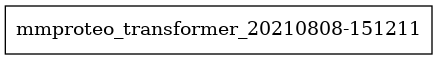

In [38]:
tf.keras.utils.plot_model(
    model=model,
    to_file=os.path.join(MODEL_PATH, "model.png"),
    show_shapes=True,
    expand_nested=True,
)

In [39]:
with open(os.path.join(MODEL_PATH, "summary.txt"), 'w') as file:
    def write_lines(line: str) -> None:
        file.write(line)
        file.write("\n")


    model.summary(print_fn=write_lines)
model.summary()

Model: "mmproteo_transformer_20210808-151211"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
on_device_embedding (OnDevic multiple                  11264     
_________________________________________________________________
transformer_encoder (Transfo multiple                  15752704  
_________________________________________________________________
transformer_decoder (Transfo multiple                  21000704  
_________________________________________________________________
relative_position_embedding  multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
source_embedding (Conv1D)    m

In [40]:
try:
    with open(os.path.join(MODEL_PATH, "model.json"), 'w') as file:
        file.write(model.to_json())

    with open(os.path.join(MODEL_PATH, "model.yaml"), 'w') as file:
        file.write(model.to_yaml())
except NotImplementedError as e:
    print("not implemented")

not implemented


## Training the Tensorflow Model

In [42]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 1e-05,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.98,
 'epsilon': 1e-09,
 'amsgrad': False}

In [43]:
decode_idx: Callable[[np.ndarray], np.ndarray] = np.vectorize(idx_to_char.get)

evaluator = evaluation.SequenceEvaluator(
    dataset=datasets[EVAL_TYPE],
    decode_func=decode_idx,
    batch_size=BATCH_SIZE,
    separator=" ",
    padding_character=PROCESSING_INFO['padding_characters'][SEQ],
)

In [44]:
callback_list = callbacks.create_callbacks(
            tensorboard=True,
            progressbar=False,
            reduce_lr=False,
            early_stopping=False,
            checkpoints=True,
            csv=False,
            base_path=MODEL_PATH,
)

In [45]:
WARMUP_STEPS = 4000
STEPS_PER_EPOCH = 200

In [63]:
last_model = None

learning_rate = 10**-6#EMBEDDING_WIDTH**-0.5 * min(epoch**-0.5, epoch * WARMUP_STEPS**-1.5)

while True:
    error_count = 0
    training_dataset = datasets[TRAINING_TYPE].repeat()
    validation_dataset = datasets[TEST_TYPE].repeat()
    
    for epoch in range(1, 10000):
        logger.info(f"epoch {epoch}:")

        tf.keras.backend.set_value(model.optimizer.learning_rate, learning_rate)
        logger.debug(str(model.optimizer.get_config()))

        try:
            history = model.fit(
                x=training_dataset,
                validation_data=validation_dataset,
                validation_steps=STEPS_PER_EPOCH//10,
                epochs=epoch,
                steps_per_epoch=STEPS_PER_EPOCH,
                callbacks=callback_list,
                initial_epoch=epoch-1,
            )
            logger.debug(str(history))
        except tf.errors.InvalidArgumentError as e:
            logger.warning(f"Training error: {e}")
            error_count += 1
            if error_count > 10:
                logger.warning("abort training, because of too many NaN loss results")
                break

        eval_df, (x_eval, y_eval, y_pred) = evaluator.evaluate_model_visually(
            model=model,
            sample_size=20,
            keep_separator=True,
        )
        display(eval_df)
    last_model = model
    model = create_model()
    learning_rate *= 0.5

2021-08-08 16:24:34,881 - mmproteo_attention_model: epoch 1:
2021-08-08 16:24:34,890 - mmproteo_attention_model: DEBUG: {'name': 'Adam', 'learning_rate': 1e-07, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.98, 'epsilon': 1e-09, 'amsgrad': False}


INFO:tensorflow:batch_all_reduce: 156 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 156 all-reduces with algorithm = nccl, num_packs = 1
  4/200 [..............................] - ETA: 5:06 - loss: nan - sparse_categorical_accuracy: 0.2101

KeyboardInterrupt: 

## Evaluating the Tensorflow Model

In [ ]:
evaluator.evaluate_model(model)

In [ ]:
eval_df, (x_eval, y_eval, y_pred) = evaluator.evaluate_model_visually(
    model=model,
    sample_size=20,
    keep_separator=True,
)
eval_df

In [ ]:
eval_df.predicted.map(print)
None

broken loss function?

In [ ]:
np.argmax(y_pred[0], axis=1)

In [ ]:
datasets[EVAL_TYPE].take(1)

In [ ]:
list(datasets[EVAL_TYPE].unbatch().batch(1).take(1).as_numpy_iterator())[0][0]

In [ ]:
model.predict(datasets[EVAL_TYPE].unbatch().batch(1).take(1))

In [ ]:
y_pred.shape

In [ ]:
y_pred